In [751]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize

В первую очередь проведем сравнение градиентных методов на задаче без ограничений:

# Градиентный спуск

$$
x_{k+1} = x_k - \alpha_k \nabla f(x_k).
$$

In [1]:
# градиентный спуск
def GradientDescent(f, gradf, x0, eps, num_iter, search_method, **kwargs):
    opt_arg = {"f": f, "grad_f": gradf, "curr_iter": 0, "eps": eps}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
        
    x, iter_time = [], []
    x.append(x0)
    
    start = time.time()
    gradient = gradf(x[-1])
    while np.linalg.norm(gradient) >= eps and opt_arg["curr_iter"] < num_iter:
        alpha = search_method(x[-1], gradient, **opt_arg)
        x.append(x[-1] - alpha * gradient)
        opt_arg["curr_iter"] += 1
        iter_time.append(time.time() - start)
        gradient = gradf(x[-1])
    finish = time.time()
    
    full_time = finish - start
    x = np.array(x)
    iter_time = np.array(iter_time)
    res = {"sol": x[-1], "x": x, "num_iter": x.shape[0] - 1, "full_time": full_time, "iter_time": iter_time}
    return res

Различные способы выбора шага:

1. $\alpha_k = const$ - постоянный шаг
2. $\alpha_k = \frac{\alpha}{\sqrt{k+1}}$ - итерационно уменьшающийся шаг
3. $\alpha_k = \arg \min_{\alpha \geqslant 0}{f(x_k - \alpha \nabla f(x_k))}$ - наискорейший спуск
4. Выбор шага по правилу Армихо: для некоторого $0 < \beta_1 < 1$ выполнено достаточное условие убывания:
$$ f(x_{k+1}) \leqslant f(x_k) + \beta_1\alpha_k\langle\nabla f(x_k), h_k\rangle$$.
5. Выбор шага по правилу Вольфе: в дополнение к условию Армихо выполнено условие кривизны: для некоторого
$\beta_1 < \beta_2 < 1$ верно:
$$ \langle \nabla f(x_{k+1}),h_k)\rangle  \geqslant \beta_2 \langle \nabla f(x_k), h_k\rangle$$

In [776]:
## Различные способы выбора шага alpha в методе градиентного спуска

# постоянный шаг
def const_step_size(x, gradient, **kwargs):
    return kwargs["stepsize"]

# априорно заданная последовательность
def iter_step_size(x, gradient, **kwargs):
    return kwargs["stepsize"] / ((kwargs["curr_iter"] + 1) ** (1/2))

In [781]:
# Выбор шага по правилу Армихо - выполнено условие достаточного убывания (beta < 0.5, rho < 1)
def armijo_step_size(x, gradient, **kwargs):
    rho   = kwargs["rho"]
    beta  = kwargs["beta"]
    f     = kwargs["f"]
    alpha = kwargs["init_alpha"]

    val = f(x)
    x_next = x - alpha * gradient
    while f(x_next) > val + beta * np.array(gradient).dot(x_next - x):
        alpha *= rho
        x_next = x - alpha * gradient
    return alpha

# Выбор шага по правилу Вольфе - выполнены условия достаточного убывания и кривизны (0 < beta1 < beta2 < 1, rho < 1)
def wolfe_step_size(x, gradient, **kwargs):
    rho   = kwargs["rho"]
    beta1 = kwargs["init_beta1"]
    beta2 = kwargs["init_beta2"]
    f     = kwargs["f"]
    gradf = kwargs["grad_f"]
    alpha = kwargs["init_alpha"]
    
    val = f(x)
    x_next = x - alpha * gradient
    while f(x_next) > val + beta1 * np.array(gradient).dot(x_next - x) or gradf(x_next).dot(gradient) > beta2 * np.array(gradient).dot(np.array(gradient)): 
        alpha *= rho
        x_next = x - alpha * gradient
    return alpha

In [782]:
# наискорейший спуск
def localize(f, x, gradient):
    pow_ = 0
    while f(x - (2 ** pow_) * gradient) > f(x - (2 ** (pow_ + 1)) * gradient):
        pow_ += 1
    left = 0
    if not pow_:
        left = 2 ** (pow_ - 1)
    right = 2 ** (pow_ + 1)
    return (left, right)
    
def best_step_size(x, gradient, **kwargs):
    f = kwargs["f"]
    left, right = localize(f, x, gradient)
    
    prec = 1e-5
    while right - left > prec:
        len_ = right - left
        first = left + len_ / 3
        second = left + len_ * 2 / 3
        if f(x - first * gradient) < f(x - second * gradient):
            right = second
        else:
            left = first
    return (left + right) / 2

# Сравнение различных способов выбора шага

In [788]:
def build_graphs(f, gradf, x0, num_iter, methods, labels, **kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    axs[0,0].set_title(r'График зависимости $||\nabla(f(x_k))||_2$ от номера итерации $n$', fontsize=18)
    axs[0,1].set_title(r'График зависимости $||\nabla(f(x_k))||_2$ от номера итерации $n$ (Лог шкала)', fontsize=18)
    axs[1,0].set_title(r'График зависимости $||\nabla(f(x_k))||_2$ от времени $t$', fontsize=18)
    axs[1,1].set_title(r'График зависимости $||\nabla(f(x_k))||_2$ от времени $t$ (Лог шкала)', fontsize=18)
    for method in methods:
        res = GradientDescent(f, gradf, x0, 1e-6, num_iter, method, **kwargs)
        grad_norm = np.array([np.linalg.norm(gradf(res["x"][i])) for i in range(len(res["x"]))])
        time_ = np.zeros(res["num_iter"] + 1)
        time_[1:] = res["iter_time"]
        label_ = labels[methods.index(method)]
        axs[0,0].plot(np.arange(1, res["num_iter"] + 2), grad_norm, label=label_)
        axs[0,1].semilogy(np.arange(1, res["num_iter"] + 2), grad_norm, label=label_)
        axs[1,0].plot(time_, grad_norm, label=label_)
        axs[1,1].semilogy(time_, grad_norm, label=label_)
    for (i,j) in [(0,0),(0,1),(1,0),(1,1)]:
        axs[i,j].legend()
    plt.show()

На примере функции $f_0 = \sum_{i = 0}^n x_i^2$:

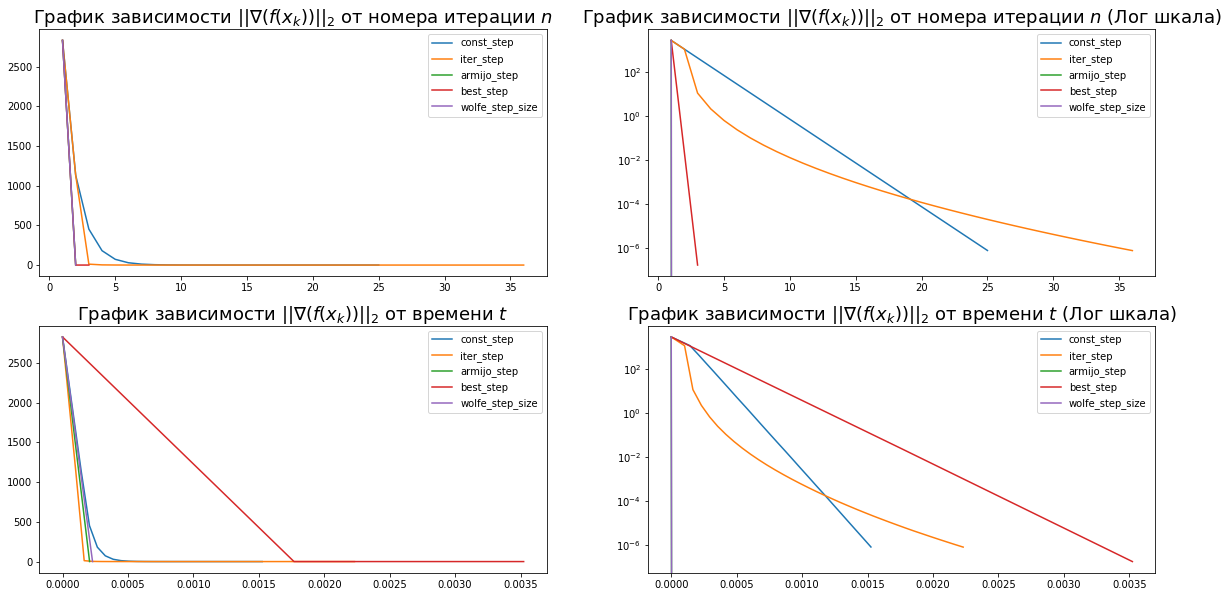

In [789]:
methods = [const_step_size, iter_step_size, armijo_step_size, best_step_size, wolfe_step_size]
labels  = ['const_step', 'iter_step', 'armijo_step', 'best_step', 'wolfe_step_size']
args = {"stepsize": 0.7, 'rho': 0.5, "init_alpha": 1, "beta": 0.3, "init_beta1": 0.3, "init_beta2": 0.8}

f = lambda x: sum(x ** 2)
gradf = lambda x: 2 * x
x0 = np.array([1000., 1000.])

build_graphs(f, gradf, x0, 100, methods, labels, **args)

На примере функции $f_0 = \sum_{i = 0}^n x_i\log(x_i+1)$:

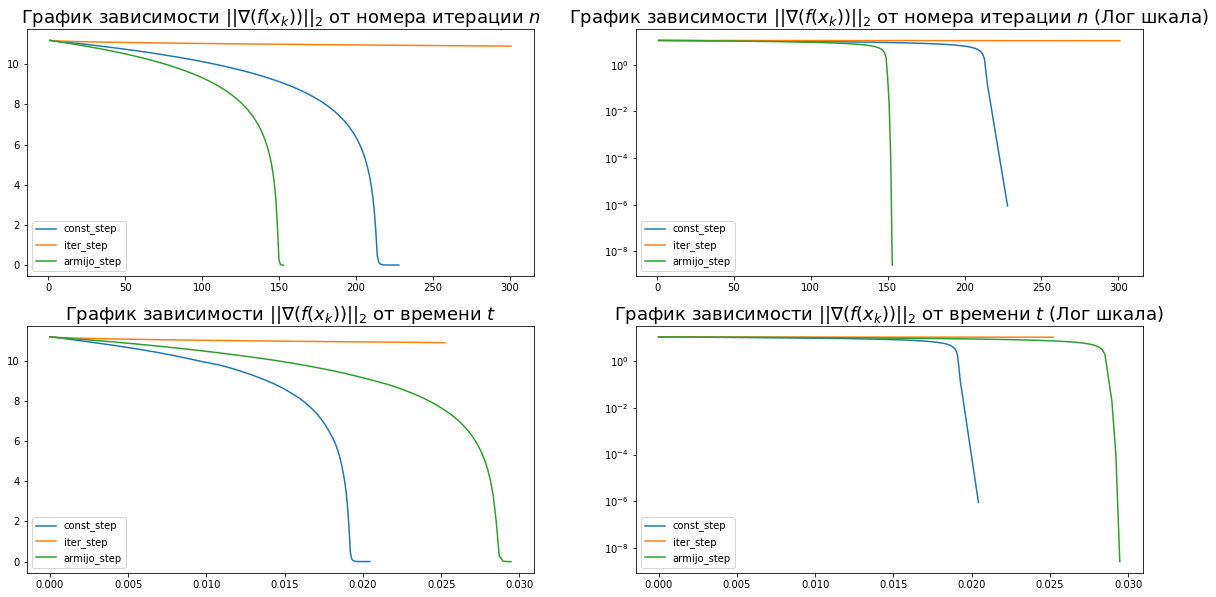

In [790]:
methods = [const_step_size, iter_step_size, armijo_step_size]
labels  = ['const_step', 'iter_step', 'armijo_step']
args = {"stepsize": 0.7, 'rho': 0.5, "init_alpha": 1, "beta": 0.3, "init_beta1": 0.3, "init_beta2": 0.8}

F = lambda x: x * np.log(x + 1)
gradF = lambda x: np.log(x + 1) + x / (x + 1)
f = lambda x: np.sum(F(x))
gradf = lambda x: np.log(x + 1) + x / (x + 1)
x0 = np.array([1000., 1000.])

build_graphs(f, gradf, x0, 300, methods, labels, **args)

# Выводы:
1. На примере простых функций, подходящих под условие задачи, было проверено, что лучше всего себя показывает наискорейший спуск и спуск с шагом по правилу Армихо/Вольфе, высокая точность достигается за несколько итераций. Однако эти способы являются самыми дорогими с точки зрения временных затрат.
2. При постоянном шаге метод стабильно сходится, однако для этого ему может потребоваться достаточно много итераций.
3. Итерационный способ выбора является палкой о двух концах, если выбрать начальную точку довольно далеко от минимума, шаг слишком быстро затухнет, раньше чем мы достаточно приблизимся к нужной точке, поэтому метод не сойдется к реальному минимуму. С другой стороны, если мы выбрали начальное приближение в малой окрестности минимума, такой способ будет сходиться быстрее постоянного шага.